In [1]:
import random
import imghdr
import shutil
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np


if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

print(tf.config.list_physical_devices("GPU"))


def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels


Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Importação dos dados

In [2]:
train_dir = "/home/dell/Documentos/Untitled Folder/data/train/"
validation_dir = "/home/dell/Documentos/Untitled Folder/data/val/"
test_dir = "/home/dell/Documentos/Untitled Folder/data/test/"

training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             labels="inferred",
                                             label_mode="int",
                                             batch_size=32,
                                             image_size=(450, 450))

val_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  labels="inferred",
                                                  label_mode="int",
                                                  batch_size=32,
                                                  image_size=(450, 450))

test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  labels="inferred",
                                                  label_mode="int",
                                                  batch_size=32,
                                                  image_size=(450, 450))

os.chdir('/home/dell/Documentos/Untitled Folder/')

Found 14226 files belonging to 2 classes.
Found 3000 files belonging to 2 classes.
Found 391 files belonging to 2 classes.


## Data Augmentation

In [3]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

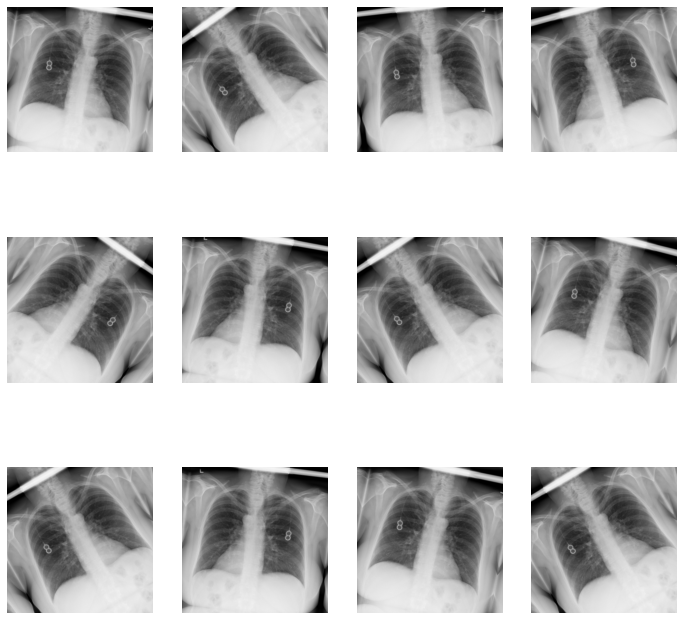

In [4]:

for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

## Modelo base

In [5]:
base_model = keras.applications.Xception(
    weights='imagenet',  
    input_shape=(450, 450, 3),
    include_top=False)  

base_model.trainable = False

In [6]:
inputs = keras.Input(shape=(450, 450, 3))
x = data_augmentation(inputs) 
x = tf.keras.applications.xception.preprocess_input(x)

In [7]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())

model.fit(training_set, epochs=20, validation_data=val_dataset)

Epoch 1/20
 47/445 [==>...........................] - ETA: 3:00 - loss: 0.3537 - binary_accuracy: 0.8910

In [ ]:
y_test = get_labels_from_tfdataset(test_dataset)

model.evaluate(test_dataset, batch_size=445, verbose=1)

In [ ]:
y_pred = model.predict(test_dataset, batch_size=445, verbose=1)

In [ ]:

df_cm = confusion_matrix(y_test, y_pred.argmax(axis=1))

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
accuracy_score(y_test, y_pred.argmax(axis=1))

## Treinando com novos pesos

In [ ]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=keras.metrics.BinaryAccuracy())


# prevent overfit

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

#rm -rf logs
%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]
# model fit

model.fit(training_set, epochs=20,validation_data=val_dataset,callbacks=callbacks)

In [ ]:
model.evaluate(test_dataset, batch_size=445, verbose=1)

In [ ]:
y_pred = model.predict(test_dataset, batch_size=445, verbose=1)

In [ ]:
df_cm = confusion_matrix(y_test, y_pred.argmax(axis=1))

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


In [ ]:
accuracy_score(y_test, y_pred.argmax(axis=1))